In [28]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

In [15]:
df = pd.read_csv('AEP_hourly.csv', index_col=[0], parse_dates=[0])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


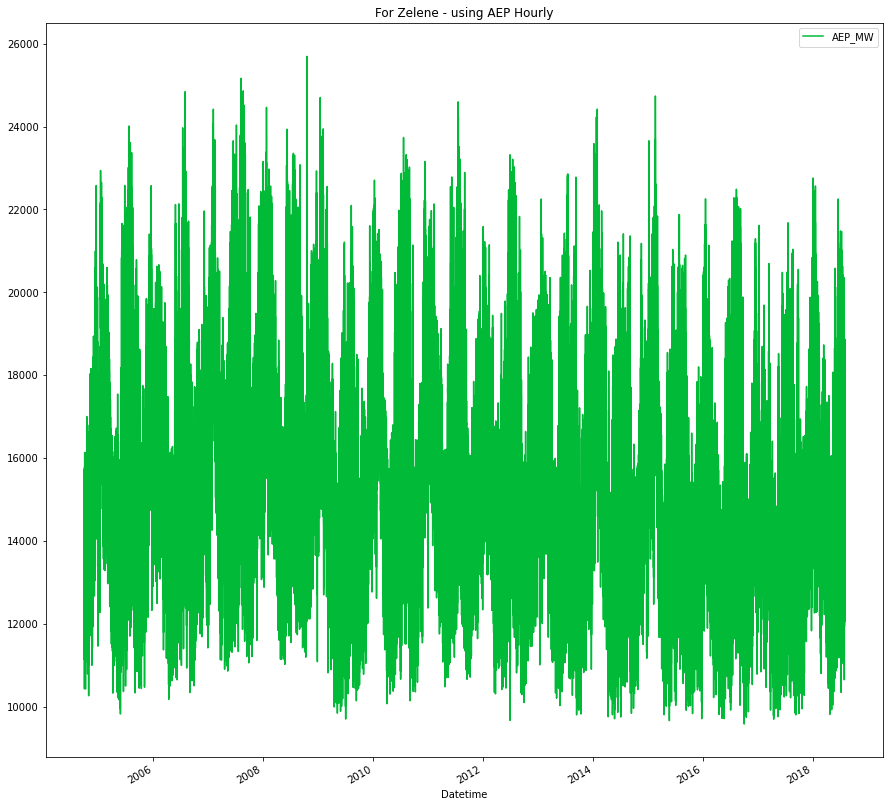

In [16]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

df.plot(figsize=(15,15), color=color_pal[3], title='For Zelene - using AEP Hourly')

In [17]:
# We assess ADF Statistics to the critical values at 1%, 5%, and 10%. Then we consider P-Value to 0.05
result = adfuller(df['AEP_MW'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -16.44681210468681
p-value: 2.399011324001736e-29
Critical Values:
	1%: -3.430403955318047
	5%: -2.8615638474512295
	10%: -2.566782693155802


#^ Inference above shows that the ADF statistics is way lower than the Critical Values (1%,5%,10%) and the p-value is significantly greater than 0.05

<Figure size 2880x1440 with 0 Axes>

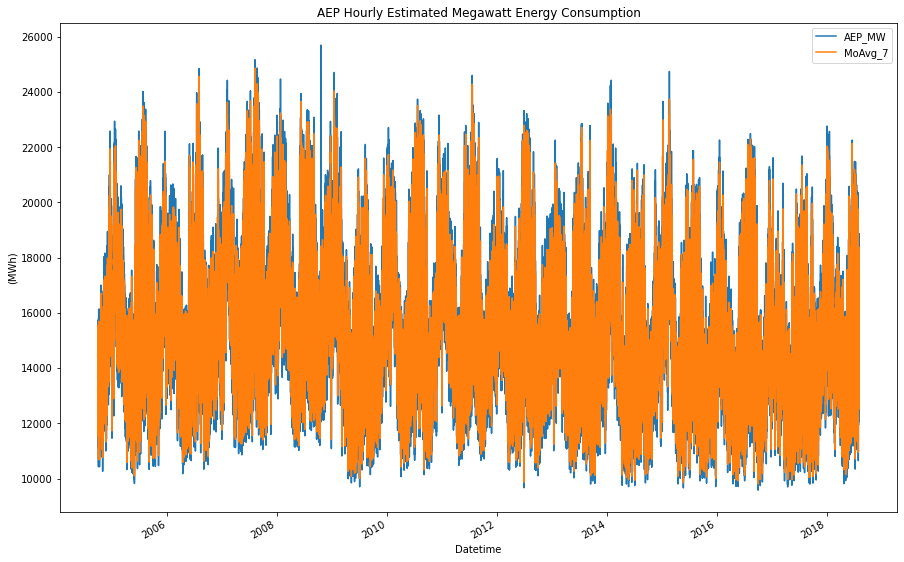

In [19]:
df["year"] = df.index.year
df["qtr"] = df.index.quarter
df["mon"] = df.index.month
df["week"] = df.index.week
df["day"] = df.index.weekday
df["ix"] = range(0,len(df))
df[["MoAvg_7", "movstd_7"]] = df.AEP_MW.rolling(7).agg([np.mean, np.std])
df[["MoAvg_30", "movstd_30"]] = df.AEP_MW.rolling(30).agg([np.mean, np.std])
df[["MoAvg_90", "movstd_90"]] = df.AEP_MW.rolling(90).agg([np.mean, np.std])
df[["MoAvg_365", "movstd_365"]] = df.AEP_MW.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(40,20))
df[["AEP_MW", "MoAvg_7"]].plot(figsize = (15,10), title="AEP Hourly Estimated Megawatt Energy Consumption")
plt.ylabel("(MWh)")
plt.show()

In [13]:
# Splitting & Training the Dataset for Validation
split_date = '2017-01-01'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [29]:
mean = np.mean(df.AEP_MW.values)
std = np.std(df.AEP_MW.values)
skew = skew(df.AEP_MW.values)
ex_kurt = kurtosis(df.AEP_MW)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.37899335414252666 
Kurtosis: 2.788681068629315


In [30]:
# Shapiro Test ~> Concludcing H0 to assess significant level and hypothesis.
def shapiro_test(df, alpha=0.05):
    stat, pval = shapiro(df)
    print("H0: df was drawn from a Normal Ditribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))
        
shapiro_test(df.AEP_MW, alpha=0.05)

H0: df was drawn from a Normal Ditribution
pval 0.0 is lower than significance level: 0.05, therefore null hypothesis is rejected


C:\Users\mulli\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


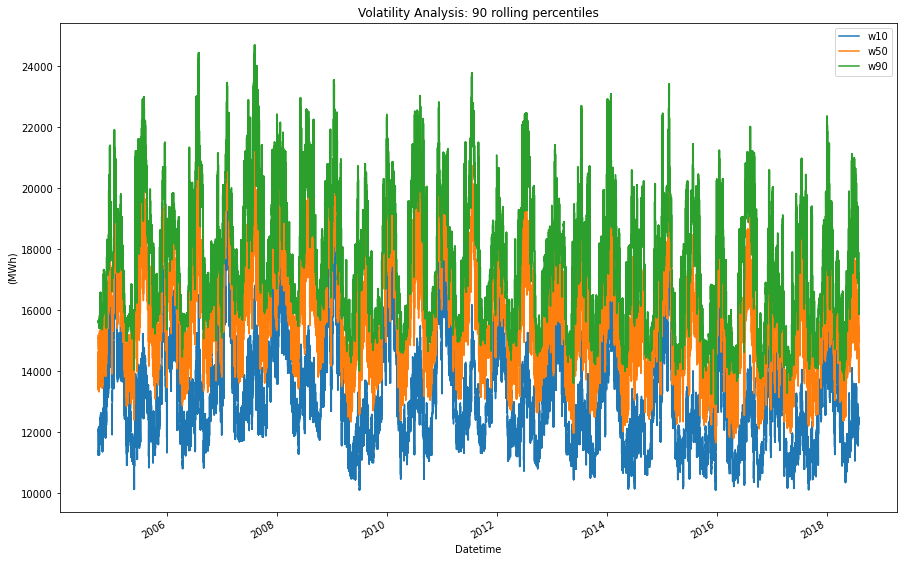

In [35]:
#Window = 90 ~> 90 is the number of observations used for calculating the statistic. Each window is a fized size. An offset of the time period between each window. 
df_rolling = df.AEP_MW.rolling(window=90)
df['w10'] = df_rolling.quantile(0.1).to_frame("w10")
df['w50'] = df_rolling.quantile(0.5).to_frame("w50")
df['w90'] = df_rolling.quantile(0.9).to_frame("w90")

df[["w10", "w50", "w90"]].plot(figsize = (15,10), title="Volatility Analysis: 90 rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

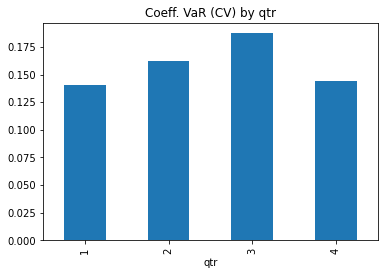

In [36]:
# Coefficient Variance by the Quarter (Q1,Q2,Q3,Q4) for AEP MW flow
df.groupby("qtr")["AEP_MW"].std().divide(df.groupby("qtr")["AEP_MW"].mean()).plot(kind="bar")
plt.title("Coeff. VaR (CV) by qtr")
plt.show()

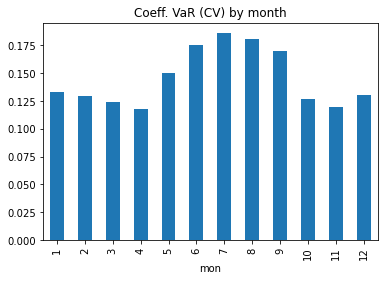

In [37]:
# Coefficient Variance by the Month for AEP MW flow
df.groupby("mon")["AEP_MW"].std().divide(df.groupby("mon")["AEP_MW"].mean()).plot(kind="bar")
plt.title("Coeff. VaR (CV) by month")
plt.show()

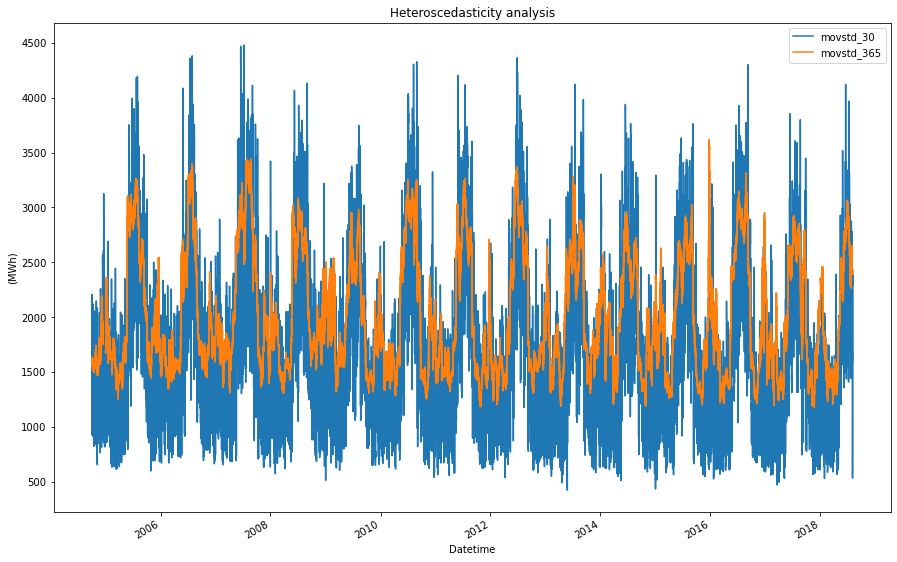

In [44]:
df[["movstd_30", "movstd_365"]].plot(figsize = (15,10), title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

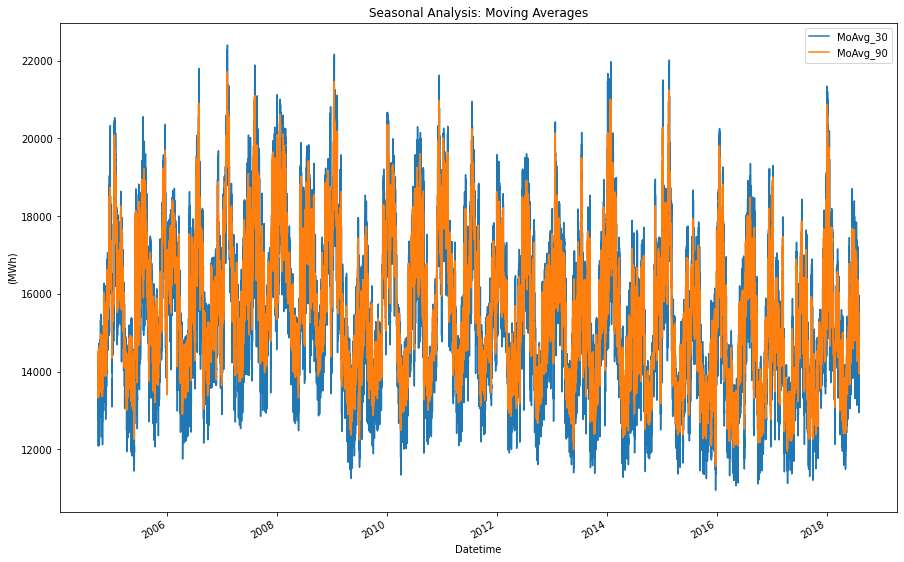

In [43]:
df[["MoAvg_30", "MoAvg_90"]].plot(figsize = (15,10), title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

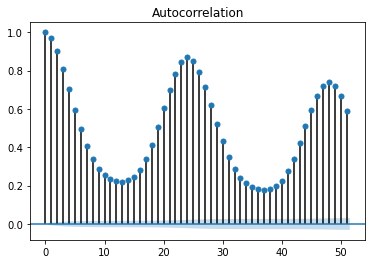

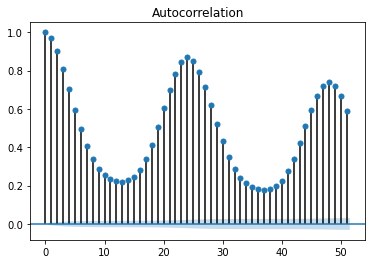

In [58]:
plot_acf(df['AEP_MW'])

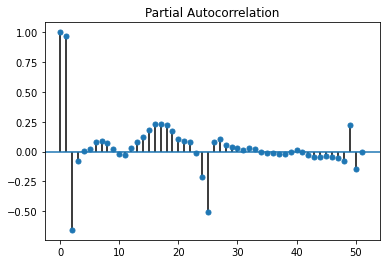

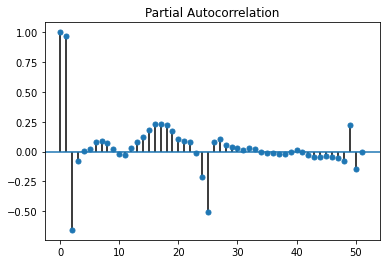

In [59]:
plot_pacf(df['AEP_MW'])

In [139]:
#Made a model
model = ARIMA(endog = df['AEP_MW'].ravel(),
              order = (1,0,1))
result = model.fit(start_ar_lags = 1)

In [140]:
result.resid

array([-2021.51372004,  -665.66337565,  -141.2453467 , ...,
          58.48450697,  -184.83313136,   -97.73854919])

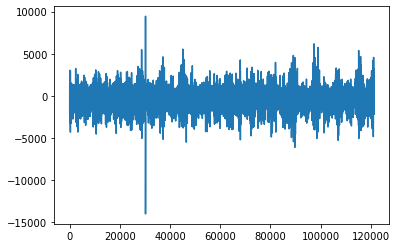

In [141]:
plt.plot(result.resid)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.7000e+01, 4.7200e+02,
        6.9539e+04, 5.1095e+04, 1.4100e+02, 7.0000e+00, 1.0000e+00]),
 array([-14005.49820277, -11660.16926113,  -9314.84031948,  -6969.51137784,
         -4624.18243619,  -2278.85349455,     66.4754471 ,   2411.80438874,
          4757.13333039,   7102.46227203,   9447.79121368]),
 <a list of 10 Patch objects>)

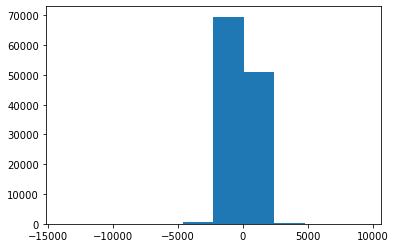

In [142]:
plt.hist(result.resid)

In [143]:
print(f'MAE: {np.abs(np.mean(result.resid))}')

MAE: 0.017424180828324566


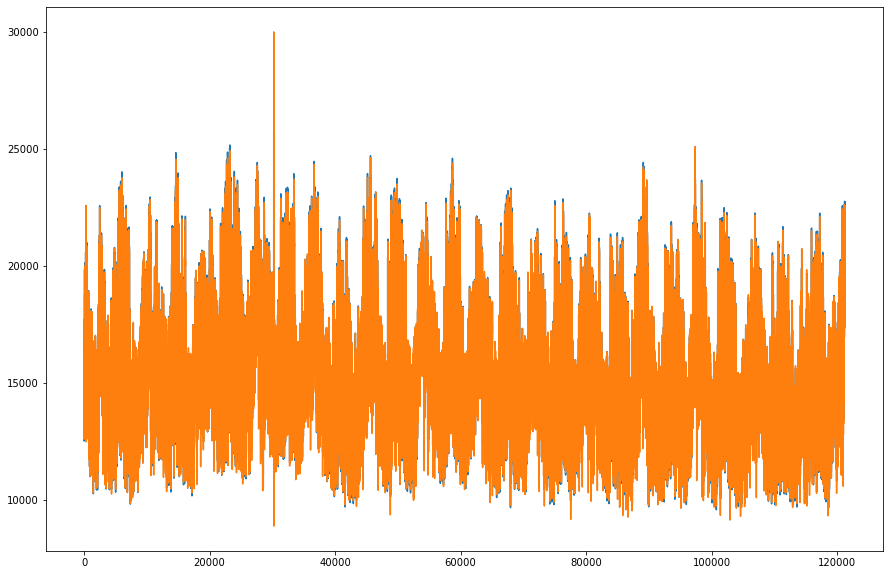

In [144]:
plt.figure(figsize = (15,10))
plt.plot(df['AEP_MW'].ravel())
plt.plot(result.fittedvalues)

In [159]:
result.predict(1,264)

array([13530.66337565, 12718.2453467 , 12646.15892018, 12592.45242994,
       12841.93803765, 13252.66837896, 13999.0835331 , 14504.17172324,
       14864.32997859, 15006.00902732, 15288.86527692, 14890.42843972,
       14798.75681781, 14427.86213996, 14363.10779873, 14042.79063412,
       14646.93371451, 15455.9490684 , 15173.56215914, 14605.89938896,
       14293.45612945, 13987.57242439, 13315.07731914, 12800.3477446 ,
       14818.87737755, 13170.23166616, 13689.21684367, 13321.58837547,
       13692.8834291 , 14402.31603978, 15422.1404298 , 15934.76088246,
       16078.08687696, 16294.45451328, 16377.57238342, 15986.81644811,
       15816.84938333, 15344.0445794 , 15149.93476428, 15019.08041219,
       15248.69475408, 16480.6435582 , 16474.50007375, 16182.88906486,
       16209.33181499, 15769.92325644, 14935.92090141, 14057.90878979,
       15825.45692531, 14213.33664039, 14696.33373961, 14348.37240825,
       14668.86471469, 15317.9195427 , 16347.86591845, 17212.82173785,
      

In [153]:
result.fittedvalues

array([15499.51372004, 13530.66337565, 12718.2453467 , ...,
       20761.51549303, 20599.83313136, 20090.73854919])